In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [407]:
import os, shutil, codecs, gensim, string, re
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from unidecode import unidecode
from collections import Counter
from nltk.corpus import stopwords

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [305]:
stoplist = stopwords.words()

In [361]:
bpath = '/Users/erickpeirson/Downloads/161019_Gregor_txts'
opath = '/Users/erickpeirson/Downloads/gregor_grouped_2'

In [499]:
for cl in set(class_map.values()):
    try:
        os.mkdir(os.path.join(opath, cl))
    except OSError:
        pass

In [500]:
for fname in os.listdir(bpath):
    fpath = os.path.join(bpath, fname)
    fname = unidecode(fname.decode('utf-8'))
    if fname not in class_map:
        continue
        
    tpath = os.path.join(opath, class_map[fname], fname)
    shutil.copy(fpath, tpath)

In [501]:
def normalize(token):
    return unidecode(token).lower().translate(string.maketrans("",""), string.punctuation)

In [502]:
unique_classes = list(set(class_map.values()))

In [503]:
documents = []
fnames = []
classes = []

for cl in unique_classes:
    cl_path = os.path.join(opath, cl)
    for fname in os.listdir(cl_path):
        fnames.append(fname)
        classes.append(cl)
        fpath = os.path.join(cl_path, fname)
        with codecs.open(fpath, 'r', encoding='utf-8') as f:
            raw = f.read()
        documents.append([normalize(token) for token in raw.split()])

In [504]:
phrase_model = gensim.models.phrases.Phrases(documents)

In [505]:
bigrams = phrase_model[documents]

In [506]:
trigram_model = gensim.models.phrases.Phrases(bigrams)

In [507]:
trigrams = trigram_model[bigrams]

In [508]:
term_counts_global = Counter()
term_counts_doc = Counter()
for doc in trigrams:
    for term in doc:
        term_counts_global[term] += 1
    for term in set(doc):
        term_counts_doc[term] += 1

In [509]:
def is_int(token):
    try:
        int(token)
        return True
    except:
        return False

In [510]:
def has_int(token):
    return any([is_int(char) for char in token])

In [511]:
def keep(token):
    return len(token) > 2 \
        and token not in stoplist \
        and all([part not in stoplist for part in token.split('_')]) \
        and term_counts_doc[token] > 1 \
        and term_counts_doc[token] < 0.5*len(trigrams) \
        and not is_int(token) \
        and not has_int(token)

In [512]:
tokens = []
for doc in trigrams:
    tokens += doc

In [513]:
unique_tokens = set(tokens) - set([''])

In [514]:
keep_tokens = [token for token in unique_tokens if keep(token)]

In [515]:
vocabulary = {term: i for i, term in enumerate(keep_tokens)}

In [544]:
lookup = {v:k for k,v in vocabulary.iteritems()}

In [516]:
corpus = np.zeros((len(bigrams), len(vocabulary)))

In [517]:
for i, doc in enumerate(trigrams):
    for token in doc:
        j = vocabulary.get(token, None)
        if not j:
            continue
        corpus[i, j] += 1.

In [518]:
corpus.max()

487.0

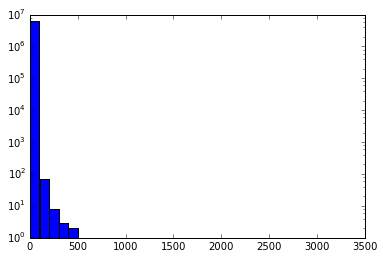

In [519]:
plt.hist(corpus.flat, log=True, bins=np.arange(0, 3500, 100))
plt.show()

In [520]:
len(bigrams)

178

In [521]:
frequencies = (corpus.T/corpus.sum(axis=1)).T

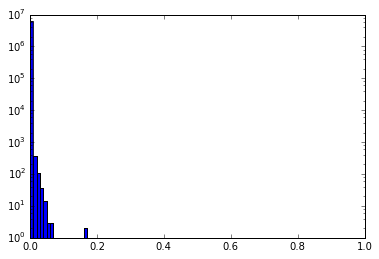

In [522]:
plt.hist(frequencies.flat, log=True, bins=np.arange(0, 1, 0.01))
plt.show()

In [523]:
transformer = TfidfTransformer(smooth_idf=False)

In [524]:
tfidf = transformer.fit_transform(corpus)

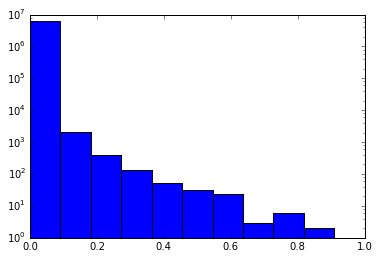

In [525]:
plt.hist(tfidf.todense().flat, log=True)
plt.show()

In [526]:
from tethne.readers import zotero

In [527]:
class_map = {}
class_data = [
    ('Compl_and_Society', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/Compl_and_Society', follow_links=False)),
    ('Economics', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/Economics', follow_links=False)),
    ('Philosophy', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/Philosophy', follow_links=False)),
    ('Politics_and_Norms', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/Politics_and_Norms', follow_links=False)),
    ('SES_Model', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/SES_Model', follow_links=False)),
    ('Theory_of_Science_and_Knowledge', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/Theory_of_Science_and_Knowledge', follow_links=False)),
    ('Sustainability_Concepts', zotero.read('/Users/erickpeirson/Downloads/161020_Categories_Gregor.zip Folder/Sustainability_Concepts', follow_links=False)),
]
for cl, corpus in class_data:
    for paper in corpus:
        try:
            key = unidecode(paper.link.split('/')[-1].replace('.pdf' ,'.txt'))
        except AttributeError:
            continue
        class_map[key] = cl

In [528]:
classes = [class_map[fname] for fname in fnames]

In [529]:
tfidf = tfidf.todense()

In [530]:
tfidf.shape

(178, 33912)

In [531]:
from itertools import cycle

In [532]:
tdata = np.concatenate((tfidf[:-10], tfidf[:-10]))
cdata = np.concatenate((classes[:-10], classes[:-10]))

In [533]:
clf = MultinomialNB().fit(tfidf[:-10], classes[:-10])
predictsions = clf.predict(tfidf[-10:])

In [534]:
i = 0
for k, p in zip(classes[-10:], predictsions):
    i += k == p
    print k, p

Compl_and_Society Sustainability_Concepts
Compl_and_Society Sustainability_Concepts
Compl_and_Society Sustainability_Concepts
Compl_and_Society Sustainability_Concepts
Compl_and_Society Sustainability_Concepts
Compl_and_Society Philosophy
Compl_and_Society Sustainability_Concepts
Compl_and_Society Philosophy
Compl_and_Society Theory_of_Science_and_Knowledge
Compl_and_Society Philosophy


In [535]:
i

0

In [536]:
K = []
P = []
for i, cl in enumerate(classes[:-1]):
    if i > 0:
        features = np.concatenate((tfidf[:i], tfidf[i+1:]))
    else:
        features = tfidf[1:]
    known = classes[:i] + classes[i+1:]
    clf = MultinomialNB().fit(features, known)
    K.append(cl)
    P.append(clf.predict(tfidf[i]))
    

In [537]:
P = [p[0] for p in P]

In [538]:
i = 0.
i2 = 0.
for k, p in zip(K, P):
    if k == p:
        i += 1.
    print k==p, '::::', k, '|', p

True :::: SES_Model | SES_Model
False :::: SES_Model | Sustainability_Concepts
True :::: SES_Model | SES_Model
False :::: SES_Model | Sustainability_Concepts
True :::: SES_Model | SES_Model
False :::: SES_Model | Sustainability_Concepts
False :::: SES_Model | Sustainability_Concepts
False :::: SES_Model | Sustainability_Concepts
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
False :::: SES_Model | Sustainability_Concepts
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
False :::: SES_Model | Sustainability_Concepts
False :::: SES_Model | Sustainability_Concepts
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
False :::: SES_Model | Sustainability_Concepts
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
True :::: SES_Model | SES_Model
F

In [539]:
1./len(set(classes)), i/(len(classes) - 1.), (i+i2)/(len(classes) - 1.)

(0.14285714285714285, 0.4406779661016949, 0.4406779661016949)

In [547]:
for i, cl in enumerate(clf.classes_):
    idx = clf.feature_log_prob_[i].argsort()[::-1][:10]
    print cl, ':::', ', '.join([lookup[x] for x in idx])

Compl_and_Society ::: resilience, sociology, agents, adaptive_capacity, vulnerability, adaptation, page, methodological_individualism, regime, complexity_theory
Economics ::: ecological_economics, sustainability_economics, ___, capability_approach, commons, justice, neoliberalism, tragedy, ecological_economists, forest_transitions
Philosophy ::: logic, transdisciplinarity, popper, philosophy, included_middle, discovery, nona, transdisciplinary, epistemic_logic, chaos
Politics_and_Norms ::: ontology, identity, indigenous, commons, feminist, lake, ecosystem_services, resilience, fish, services
SES_Model ::: resilience, ecosystems, species, ecosystem, governance, sess, variables, ___, panarchy, ecosystem_services
Sustainability_Concepts ::: sustainability_science, mlp, sustainable_development, resilience, health, lca, transitions, ontology, urban, transdisciplinary_research
Theory_of_Science_and_Knowledge ::: transdisciplinarity, transdisciplinary_research, transdisciplinary, lifeworld, t

array(['Compl_and_Society', 'Economics', 'Philosophy',
       'Politics_and_Norms', 'SES_Model', 'Sustainability_Concepts',
       'Theory_of_Science_and_Knowledge'], 
      dtype='|S31')